[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

**notes**:
- "b" defined in eq. (18) lacks multiplication by $\rho_\text{s}$ - units do not match, plot matches the one generated with $\rho_\text{s}$ included - seems a typo in eq. (18)

**extentions (see notebook cells below first figure):**
- multiple isotopes (D, $^{18}$O, $^{17}$O)
- modern parameterisations: Horita & Wesolowski '94 for D & $^{18}$O equil. fractionation, Barkan & Luz '05 for $^{17}$O, Hellmann & Harvey '20 for diffusivities
- environment ratio plot axis
- temperature dependence

In [2]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [3]:
from PySDM.physics.constants import si, PER_MILLE, in_unit, PER_CENT
import copy
from types import SimpleNamespace
from matplotlib.lines import Line2D
from PySDM_examples.Gedzelman_and_Arnold_1994.Helpers import Commons, NoFractionationSaturation, Settings
import numpy as np
from matplotlib import pyplot
import matplotlib
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.dynamics.isotopic_fractionation import HEAVY_ISOTOPES

#### derivations:

- Maxwell-Mason equation (introducing $\rho_\text{s}=\frac{p_\text{vs}}{R_\text{v}T}$, approximated for $S_\text{eq}\approx 1$ and taking into account $\frac{l_\text{v}}{R_\text{v} T} \approx 20 \gg 1$):
$$
a\frac{da}{dt} 
= f \frac{
    S - S_\text{eq}
}{
    \rho_w \left(
        \frac{R_\text{v} T }{\Psi p_\text{vs}(T)} + 
        \frac{l_\text{v}}{K T} \left(\frac{l_\text{v}}{R_\text{v} T}-1\right)
    \right)
}
\approx \frac{f}{\rho_\text{w}} \frac{S - 1}{        \frac{1}{\Psi \rho_\text{s}} + 
        \frac{l^2_\text{v}}{K R_v T^2}
}
= \frac{f \Psi \rho_\text{s}}{\rho_\text{w}} \frac{S - 1}{        1 + 
        \frac{\Psi \rho_\text{s} l^2_\text{v}}{K R_v T^2}
}
$$
where $t$ is time, $a$ is drop radius, $f$ is ventilation factor, $\Psi$ is mass diffusion coefficient, $K$ thermal diffusion coefficient, $l_\text{v}$ is latent heat of condensation, $R_\text{v}$ gas constant for water vapour, $T$ temperature, $\rho_\text{w}$ density of water, $\rho_\text{s}$ saturation vapour density.

In [4]:
CONST = Formulae().constants
print(f"lv/(Rv T) at the triple point: {CONST.l_tri / (CONST.Rv * CONST.T_tri):.3g}")
CONST = None

lv/(Rv T) at the triple point: 19.8


- expressed in terms of mass $m=\frac{4}{3}\pi a^3 \rho_\text{w}$:

$$\frac{dm}{dt} / [\text{surface}]
= \frac{d\left(\frac{4}{3}\pi a^3 \rho_\text{w}\right)}{dt} \frac{1}{4 \pi a^2}
= \rho_\text{w} \frac{da}{dt}
$$

- introducing $b=\frac{l^2_\text{v} \Psi}{K R_\text{v}T^2}$ and approximating leads to eq. (16) in the paper:

$$
\frac{dm}{dt} 
\approx 4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b \rho_\text{s}}
$$

In [5]:
paper_params = SimpleNamespace(
    formulae=Formulae(
        isotope_equilibrium_fractionation_factors='MerlivatAndNief1967',
        isotope_relaxation_timescale='ZabaEtAl',
        isotope_diffusivity_ratios='Stewart1975',
        isotope_ratio_evolution='GedzelmanAndArnold1994',
        isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
        drop_growth="Mason1971",
    ),
    isotope='2H',
    delta_v= -200 * PER_MILLE,
    xlim=(.8, 1),
    RH_unit=PER_CENT
)
K2C = paper_params.formulae.trivia.K2C
C2K = paper_params.formulae.trivia.C2K
paper_params.T = C2K(10) * si.K
T_range = (C2K(-10) * si.K, C2K(30) * si.K)
Ts = np.linspace(*T_range, 9)

BASE_INITIAL_ATTRIBUTES = {
    "dry volume": np.nan,
    "kappa times dry volume": np.nan,
    **{f"moles_{isotope}": 0 * si.mole for isotope in HEAVY_ISOTOPES},
}

In [6]:

def plot(*, fig, ax, x, ys, xlim, params: SimpleNamespace):
    temp_01 = (params.T - T_range[0])/(T_range[1] - T_range[0])
    color = (temp_01, .333, 1-temp_01)
    iso_latex = f"^{{{params.isotope[:-1]}}}{params.isotope[-1]}"
    for i, y, label in zip((0, 1), ys, [(r'S$_R$(eq)'), (r'S$_V$(eq)')]):
        if len(fig.axes)==1:
            ax.plot(x, y, label=label, color=color)
        else:
            ax[i].plot(x, y, label=label, color=color)
        
        
    fig.gca().set(
        title=f"ambient vapour $\\delta{iso_latex}$ = {in_unit(params.delta_v, PER_MILLE):.3g}‰",
        ylim=(0, 1),
        yticks=np.linspace(0, 1, 5),
        xlabel=f'${iso_latex}$: R$_{{rain}}$ / R$_{{SMOW}}$',
        ylabel='S=RH',
        xlim=xlim,
    )
    fig.gca().grid(visible=True, axis='both')

    
    return x, {'eq_22': y_eq_22, 'eq_23': y_eq_23}

In [19]:
def plot_relative_changes(
        cmn=Commons(**vars(paper_params)),
        formulae=paper_params.formulae,
        multiplicity=1,
        volume=1 * si.m**3,
        n_sd=1,
        liquid_water_content=1 * si.g / si.m**3,
        evaporated_mass_fraction=0.02,
    ):
        const = formulae.constants
        T = formulae.trivia.C2K(10) * si.K
        delta_2H = -200 * PER_MILLE
        initial_R_vap = formulae.trivia.isotopic_delta_2_ratio(delta_2H, const.VSMOW_R_2H)
        grid = (16, 16)
        molecular_R_liq = np.linspace(0.8, 1, grid[0]) * const.VSMOW_R_2H
        ylim = (0.1, 1.1)
        RH = np.linspace(*ylim, grid[1])

        total_liquid_water_mass = liquid_water_content * volume

        attributes = BASE_INITIAL_ATTRIBUTES.copy()
        attributes["multiplicity"] = multiplicity * np.ones(n_sd)
        attributes["signed water mass"] = total_liquid_water_mass / multiplicity

        rel_diff_vap = np.zeros(grid)
        rel_diff_liq = np.zeros(grid)

        for i in range(grid[0]):
            for j in range(grid[1]):
                rel_diff_vap[i, j], rel_diff_liq[i, j] = Settings.do_one_step(
                    formulae=formulae,
                    particulator=Settings.make_particulator(
                        RH=RH[i],
                        molecular_R_liq=molecular_R_liq[j],
                        formulae=formulae,
                        attributes=attributes,
                        initial_R_vap=initial_R_vap,
                        dv=volume,
                        n_sd=n_sd,
                        T=T,
                    ),
                    evaporated_mass_fraction=evaporated_mass_fraction,
                )
        phases = ["liquid", "vapour"]
        x = np.linspace(cmn.alpha_w * cmn.iso_ratio_v / cmn.vsmow_ratio, 1.1, 200)
        S_eq = {
            "liquid": NoFractionationSaturation(cmn, liquid=True)(x * cmn.vsmow_ratio),
            "vapour": NoFractionationSaturation(cmn, vapour=True)(x * cmn.vsmow_ratio)
        }
        
        fig, ax = pyplot.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
        fig.suptitle(f"$\\xi$={multiplicity:.0e}, V={volume:.0e} [m$^3$]")
        for idx, data in enumerate((rel_diff_liq, rel_diff_vap)):
            pcm = ax[idx].pcolormesh(
                molecular_R_liq / const.VSMOW_R_2H,
                in_unit(RH, PER_CENT),
                data_percent := in_unit(data, PER_CENT),
                cmap="seismic",
                vmax=(vmax := np.nanmax(np.abs(data_percent))),
                vmin=-vmax,
            )
            fig.colorbar(pcm, ax=ax[idx], extend="both")
            ax[idx].plot(x, in_unit(S_eq[phases[idx]], paper_params.RH_unit))
            ax[idx].set(
                title=f"$\\Delta R/R$ [%], R-{phases[idx]}",
                xlim=paper_params.xlim,
                ylim=(in_unit(ylim[0], paper_params.RH_unit), in_unit(ylim[1], paper_params.RH_unit)),
            )
        # ( 
        #     "molecular isotope ratio of rain normalised to atomic VSMOW [1]"
        # )
        pyplot.tight_layout()
        show_plot("R_ratios_for_liquid_and_vapour")


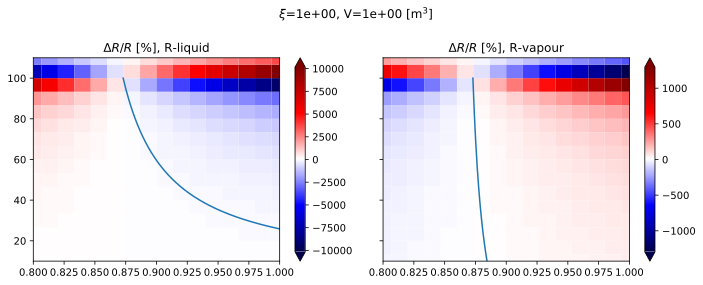

In [20]:
plot_relative_changes()

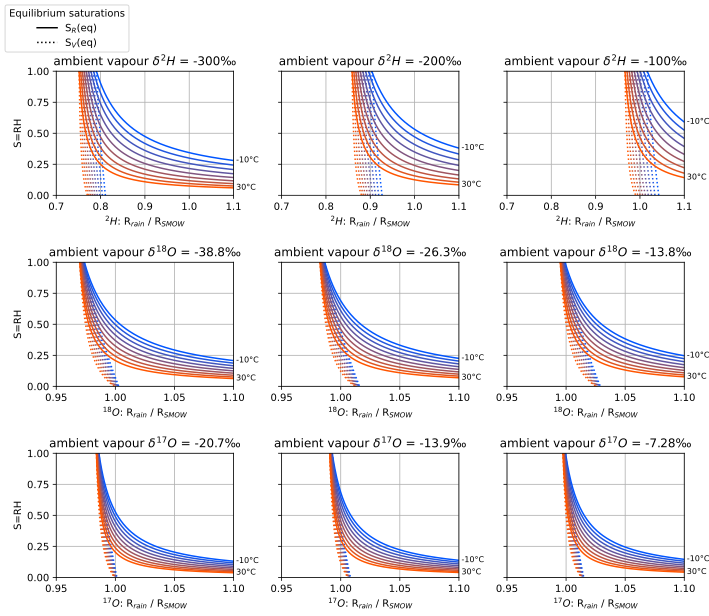

In [9]:
params = copy.deepcopy(paper_params)
params.formulae = Formulae(
    isotope_equilibrium_fractionation_factors='BarkanAndLuz2005+HoritaAndWesolowski1994',
    isotope_diffusivity_ratios='HellmannAndHarvey2020',
    isotope_meteoric_water_line='BarkanAndLuz2007+Dansgaard1964',
    isotope_ratio_evolution='GedzelmanAndArnold1994',
    isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
)
iso_mwl=params.formulae.isotope_meteoric_water_line
deltas_2H = (-300 * PER_MILLE, -200 * PER_MILLE, -100 * PER_MILLE)
deltas_18O = [iso_mwl.d18O_of_d2H(d2H) for d2H in deltas_2H]
deltas_17O = [iso_mwl.d17O_of_d18O(d18O) for d18O in deltas_18O]

plot_params = {
    'liquid': {'label': 'S$_R$(eq)', 'linestyle':'-'},
    'vapour': {'label': 'S$_V$(eq)', 'linestyle':':'},
}
fig, axs = pyplot.subplots(3, 3, figsize=(10,8), sharex=False, sharey=True) 
x_lim = {
    '2H': (.7, 1.1),
    '18O': (.95, 1.1),
    '17O': (.95, 1.1),
}
for ax_idx_iso, iso_label in enumerate(('2H', '18O', '17O')):
    x_lim_iso=x_lim[iso_label]
    for ax_idx_delta, delta_v in enumerate({
        '2H': deltas_2H,
        '18O': deltas_18O,
        '17O': deltas_17O,
    }[iso_label]):
        params.delta_v = delta_v
        params.isotope = iso_label
        ax=axs[ax_idx_iso][ax_idx_delta]
        for i, temperature in enumerate(Ts):
            params.T = temperature
            commons = Commons(**vars(params))
            x = np.linspace(commons.alpha_w * commons.iso_ratio_v / commons.vsmow_ratio, 1.1, 200)
            y_eq_liq = NoFractionationSaturation(commons, liquid=True)(x * commons.vsmow_ratio)
            y_eq_vap = NoFractionationSaturation(commons, vapour=True)(x * commons.vsmow_ratio)
            temp_01 = (params.T - T_range[0])/(T_range[1] - T_range[0])
            color = (temp_01, .333, 1-temp_01)
            iso_latex = f"^{{{params.isotope[:-1]}}}{params.isotope[-1]}"
            if i==0 or i==len(Ts)-1:
                axs[ax_idx_iso][ax_idx_delta].annotate(
                    f' {K2C(params.T):g}°C$\\!\\!\\!\\!\\!\\!$',
                    (x_lim_iso[-1], y_eq_liq[-1] - .015),
                    fontsize=8
                )
            for y, p in zip((y_eq_liq, y_eq_vap), (plot_params['liquid'], plot_params['vapour'])):
                ax.plot(x, y, color=color, linestyle=p['linestyle'])  
        ax.set(
            title=f"ambient vapour $\\delta{iso_latex}$ = {in_unit(params.delta_v, PER_MILLE):.3g}‰",
            ylim=(0, 1),
            yticks=np.linspace(0, 1, 5),
            xlabel=f'${iso_latex}$: R$_{{rain}}$ / R$_{{SMOW}}$',
            ylabel='S=RH',
            xlim=x_lim[iso_label],
        )
        ax.grid(True)
        if ax_idx_delta != 0:
            axs[ax_idx_iso][ax_idx_delta].set_ylabel('')

legend_lines = [
    Line2D([0], [0], color='black', linestyle=plot_params['liquid']['linestyle'], label='S$_R$(eq)'),
    Line2D([0], [0], color='black', linestyle=plot_params['vapour']['linestyle'], label='S$_V$(eq)'),
]

fig.legend(legend_lines, (l.get_label() for l in legend_lines),
           loc='upper left',
           title="Equilibrium saturations")

fig.tight_layout()
fig.subplots_adjust(top=0.88, bottom=0)
show_plot('plot_grid.pdf')